# Test Best Model Trained on CIFAR-10 data


## 1. Libraries

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.efficientnet import preprocess_input
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

## 2. Build Model

In [26]:
#split data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [25]:
# CIFAR-10 label names
class_names = ["airplane", "automobile", "bird", "cat", "deer",
               "dog", "frog", "horse", "ship", "truck"]

In [5]:
# Flatten labels and one-hot encode
y_train_cat = to_categorical(y_train.flatten(), num_classes=10)
y_test_cat = to_categorical(y_test.flatten(), num_classes=10)


In [16]:
def evaluate_model(model, model_name, test_dataset):
    loss, accuracy = model.evaluate(test_dataset, verbose=0)

    if hasattr(model, 'history') and model.history is not None:
        hist = model.history.history
        val_loss = hist.get('val_loss', [None])[-1]
        val_accuracy = hist.get('val_accuracy', [None])[-1]
    else:
        val_loss, val_accuracy = None, None

    print(f"{model_name} Evaluation:")
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    if val_loss is not None:
        print(f"Validation Loss: {val_loss:.4f}")
        print(f"Validation Accuracy: {val_accuracy:.4f}")

    return model, loss, accuracy, val_loss, val_accuracy

In [7]:
# image training parameter
IMG_SIZE = 224
BATCH_SIZE = 64

#preprocess
def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = preprocess_input(image)  # scales pixels to [-1,1]
    return image, label

train_ds = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train_cat))
    .shuffle(10000)
    .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

test_ds = (
    tf.data.Dataset.from_tensor_slices((X_test, y_test_cat))
    .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [13]:
# efficient net
efficientnet_base = EfficientNetB0(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# unfreeze last 60 layers
efficientnet_base.trainable = True
for layer in efficientnet_base.layers[:-60]:
    layer.trainable = False

model_eff_finetune = Sequential([
    efficientnet_base,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

# compile w low lr
model_eff_finetune.compile(
    optimizer=Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
checkpoint = ModelCheckpoint("EfficientNetB0_FineTuned.keras", monitor='val_loss', save_best_only=True)

# train
history_eff_finetune = model_eff_finetune.fit(
    train_ds,
    validation_data=test_ds,
    epochs=50
)

Epoch 1/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 101s 90ms/step - accuracy: 0.7722 - loss: 0.7545 - val_accuracy: 0.9388 - val_loss: 0.1792
Epoch 2/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 45s 57ms/step - accuracy: 0.9350 - loss: 0.1915 - val_accuracy: 0.9454 - val_loss: 0.1618
Epoch 3/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 44s 57ms/step - accuracy: 0.9545 - loss: 0.1339 - val_accuracy: 0.9500 - val_loss: 0.1536
Epoch 4/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 44s 57ms/step - accuracy: 0.9691 - loss: 0.0927 - val_accuracy: 0.9545 - val_loss: 0.1482
Epoch 5/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 44s 56ms/step - accuracy: 0.9745 - loss: 0.0759 - val_accuracy: 0.9560 - val_loss: 0.1490
Epoch 6/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 44s 56ms/step - accuracy: 0.9798 - loss: 0.0595 - val_accuracy: 0.9555 - val_loss: 0.1542
Epoch 7/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 44s 56ms/step - accuracy: 0.9833 - loss: 0.0516 - val_accuracy: 0.9547 - val_loss: 0.1658
Epoch 8/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 44s 56ms/step - accuracy: 0.9866 - loss: 0.0406 -

In [18]:
evaluate_model(model_eff_finetune, "EfficientNetB0 FineTuned", test_ds)

EfficientNetB0 FineTuned Evaluation:
Test Loss: 0.1975
Test Accuracy: 0.9605
Validation Loss: 0.1975
Validation Accuracy: 0.9605


(<Sequential name=sequential_2, built=True>,
 0.1974789947271347,
 0.9605000019073486,
 0.1974789947271347,
 0.9605000019073486)

In [14]:
model_eff_finetune.save("/content/drive/MyDrive/Ironhack/models/EfficientNetB0_FineTuned.keras")

## 3. Image Testing

In [19]:
IMG_SIZE = 224
MODEL_PATH = "/content/drive/MyDrive/Ironhack/models/EfficientNetB0_FineTuned.keras"

In [20]:
TEST_IMAGE_FOLDER = "/content/drive/MyDrive/Ironhack/models/test_images"


### 3.1 Model

In [21]:
model = load_model(MODEL_PATH)
print("Model loaded:", MODEL_PATH)

Model loaded: /content/drive/MyDrive/Ironhack/models/EfficientNetB0_FineTuned.keras


### 3.2 Preprocessing

In [22]:
def preprocess_image(img_path):
    img = Image.open(img_path).convert("RGB")
    img = img.resize((IMG_SIZE, IMG_SIZE))
    img_array = np.array(img)
    img_preprocessed = preprocess_input(img_array)
    img_preprocessed = np.expand_dims(img_preprocessed, axis=0)

    return img, img_preprocessed


### 3.3  Predicition

In [23]:
def predict_image(img_path):
    original_img, x = preprocess_image(img_path)
    preds = model.predict(x)
    pred_class = np.argmax(preds, axis=1)[0]
    pred_label = class_names[pred_class]
    confidence = preds[0][pred_class]
    plt.imshow(original_img)
    plt.title(f"Prediction: {pred_label} ({confidence:.2f})")
    plt.axis("off")
    plt.show()

    return pred_label, confidence

### 3.4 Run Predicition


Running inference on images in folder: /content/drive/MyDrive/Ironhack/models/test_images

Image: cat1.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


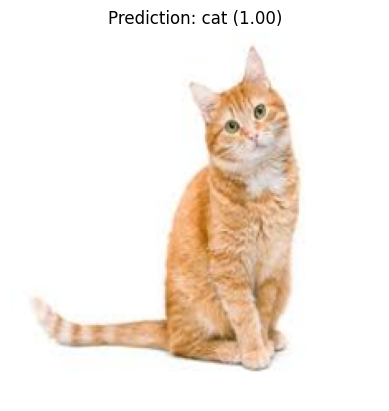

Predicted: cat (0.998)

Image: cat2.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


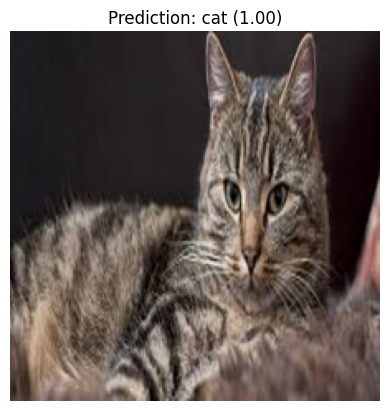

Predicted: cat (1.000)

Image: dog1.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


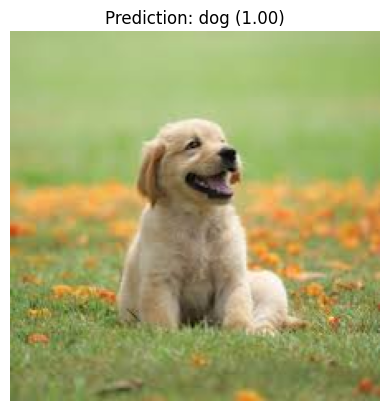

Predicted: dog (1.000)

Image: gog2.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


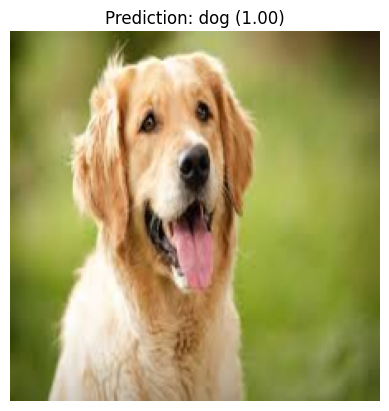

Predicted: dog (1.000)

Image: airplane1.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


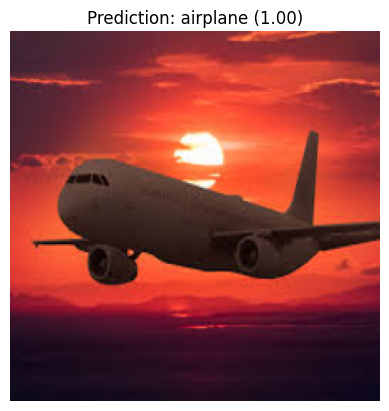

Predicted: airplane (1.000)

Image: airplane2.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


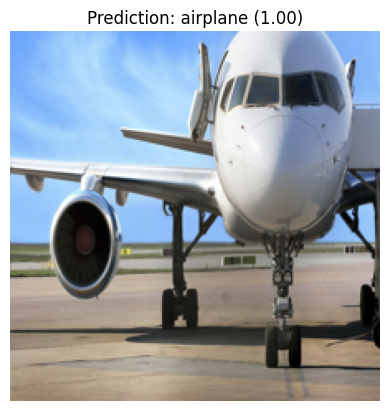

Predicted: airplane (1.000)

Image: bird1.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


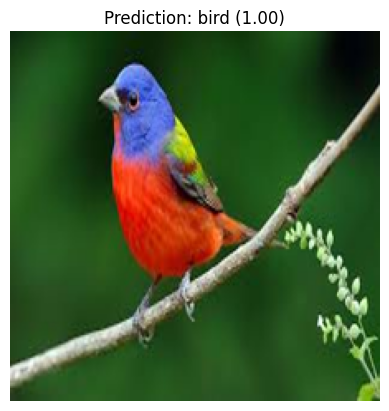

Predicted: bird (1.000)

Image: bird2.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


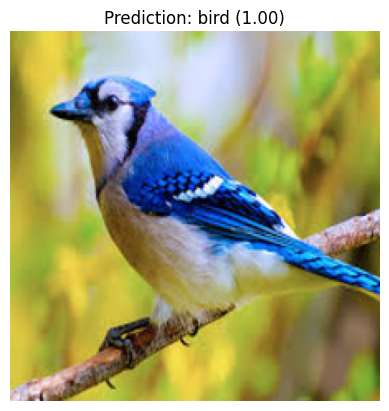

Predicted: bird (1.000)

Image: ship1.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


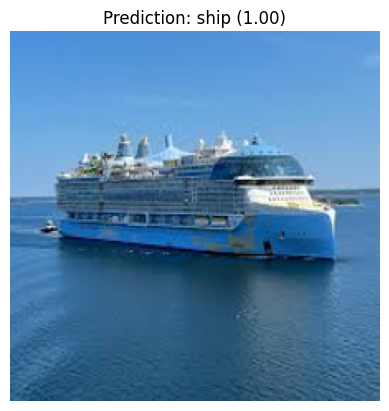

Predicted: ship (1.000)

Image: ship2.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


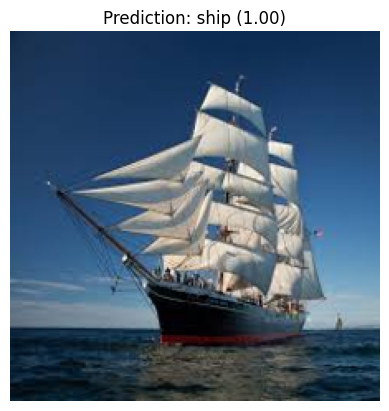

Predicted: ship (1.000)


In [27]:
print("\nRunning inference on images in folder:", TEST_IMAGE_FOLDER)

for filename in os.listdir(TEST_IMAGE_FOLDER):
    if filename.lower().endswith((".jpg", ".jpeg", ".png")):
        img_path = os.path.join(TEST_IMAGE_FOLDER, filename)
        print("\nImage:", filename)
        label, conf = predict_image(img_path)
        print(f"Predicted: {label} ({conf:.3f})")